In [28]:
import sklearn as sk
import torch
import matplotlib.pyplot as plt

In [17]:
X, y = sk.datasets.make_friedman1(n_samples=150000, n_features=10, noise=0.1, random_state=42)

In [18]:
X

array([[0.37454012, 0.95071431, 0.73199394, ..., 0.86617615, 0.60111501,
        0.70807258],
       [0.02058449, 0.96990985, 0.83244264, ..., 0.52475643, 0.43194502,
        0.29122914],
       [0.61185289, 0.13949386, 0.29214465, ..., 0.51423444, 0.59241457,
        0.04645041],
       ...,
       [0.32553159, 0.62038495, 0.39006045, ..., 0.45314303, 0.42215838,
        0.24109201],
       [0.63351938, 0.71508816, 0.60477925, ..., 0.69010283, 0.43818136,
        0.09678911],
       [0.26869524, 0.03667024, 0.188893  , ..., 0.50019969, 0.5732196 ,
        0.87743745]], shape=(150000, 10))

In [19]:
y

array([16.78090209,  6.03553307,  9.55854831, ...,  8.03258176,
       12.16568108, 14.1367532 ], shape=(150000,))

# Linear Regression Baseline

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X_train, y_train)

In [26]:
train_score = lr.score(X_train, y_train)
val_score = lr.score(X_val, y_val)

print(f"Training R² Score: {train_score:.2f}")
print(f"Validation R² Score: {val_score:.2f}")

Training R² Score: 0.75
Validation R² Score: 0.75


In [35]:
y_train_pred = lr.predict(X_train)
y_val_pred = lr.predict(X_val)

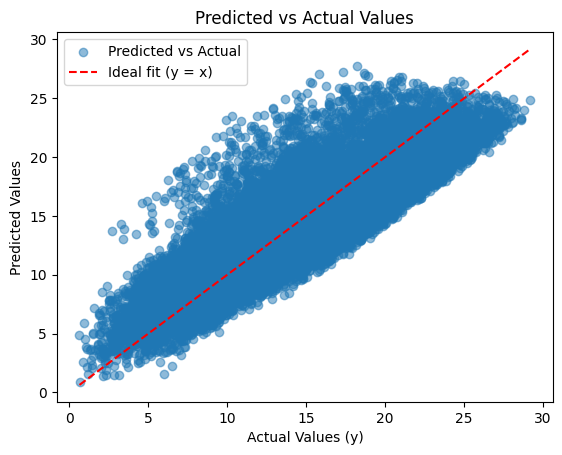

In [47]:
plt.scatter(y_val, y_val_pred, alpha=0.5, label="Predicted vs Actual")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color="red", linestyle="--", label="Ideal fit (y = x)")
plt.xlabel("Actual Values (y)")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.legend()
plt.show()

# Deep Neural Networks

In [51]:
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [52]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers):
        super(MLP, self).__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [103]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import torch.optim as optim
import numpy as np

def objective(trial):
    n_layers = trial.suggest_categorical("n_layers", [1, 5, 25])
    learning_rate = trial.suggest_categorical("lr", [1e-3, 1e-2, 1e-1])
    optimizer_name = trial.suggest_categorical("optimizer", ["SGD", "RMSprop", "Adam"])

    if n_layers == 1:
        hidden_layers = [50]
    elif n_layers == 5:
        hidden_layers = [50, 100, 50, 25, 10]
    elif n_layers == 25:
        hidden_layers = [50] * 25

    input_dim = X_train.shape[1]
    model = MLP(input_dim, hidden_layers)

    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    criterion = nn.MSELoss()

    def get_predictions_and_metrics(loader):
        preds, targets = [], []
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in loader:
                y_pred = model(X_batch)
                preds.extend(y_pred.numpy())
                targets.extend(y_batch.numpy())

        preds, targets = np.array(preds), np.array(targets)

        if np.isnan(preds).any() or np.isnan(targets).any():
            raise optuna.exceptions.TrialPruned()

        mse = mean_squared_error(targets, preds)
        r2 = r2_score(targets, preds)
        mape = mean_absolute_percentage_error(targets, preds)

        return mse, r2, mape

    train_r2_list, train_mse_list, train_mape_list = [], [], []
    val_r2_list, val_mse_list, val_mape_list = [], [], []

    epochs = 20
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

        train_mse, train_r2, train_mape = get_predictions_and_metrics(train_loader)
        val_mse, val_r2, val_mape = get_predictions_and_metrics(val_loader)

        train_r2_list.append(train_r2)
        train_mse_list.append(train_mse)
        train_mape_list.append(train_mape)
        val_r2_list.append(val_r2)
        val_mse_list.append(val_mse)
        val_mape_list.append(val_mape)

    trial.set_user_attr("train_r2", train_r2_list)
    trial.set_user_attr("train_mse", train_mse_list)
    trial.set_user_attr("train_mape", train_mape_list)
    trial.set_user_attr("val_r2", val_r2_list)
    trial.set_user_attr("val_mse", val_mse_list)
    trial.set_user_attr("val_mape", val_mape_list)

    return val_mse_list[-1]

In [104]:
import optuna

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=27)

[I 2025-03-30 14:39:13,082] A new study created in memory with name: no-name-3c8d5efd-c297-4493-b940-4bd5f827ab19
[I 2025-03-30 14:39:46,497] Trial 0 finished with value: 23.77534294128418 and parameters: {'n_layers': 5, 'lr': 0.1, 'optimizer': 'Adam'}. Best is trial 0 with value: 23.77534294128418.
[I 2025-03-30 14:40:06,892] Trial 1 finished with value: 3.9332776069641113 and parameters: {'n_layers': 1, 'lr': 0.1, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 3.9332776069641113.
[I 2025-03-30 14:40:28,162] Trial 2 finished with value: 0.029569556936621666 and parameters: {'n_layers': 1, 'lr': 0.01, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.029569556936621666.
[I 2025-03-30 14:40:54,764] Trial 3 finished with value: 0.033239901065826416 and parameters: {'n_layers': 5, 'lr': 0.01, 'optimizer': 'SGD'}. Best is trial 2 with value: 0.029569556936621666.
[I 2025-03-30 14:41:21,236] Trial 4 finished with value: 0.047174692153930664 and parameters: {'n_layers': 5, 'lr': 0.00

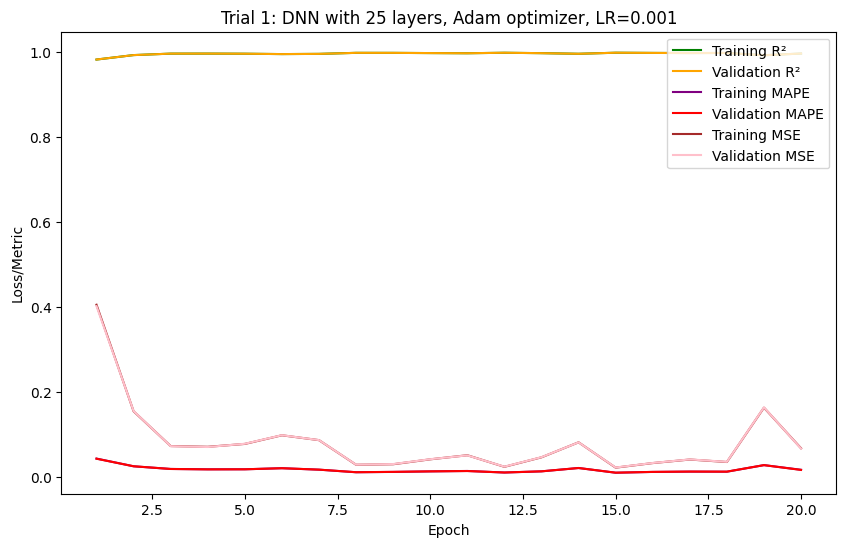

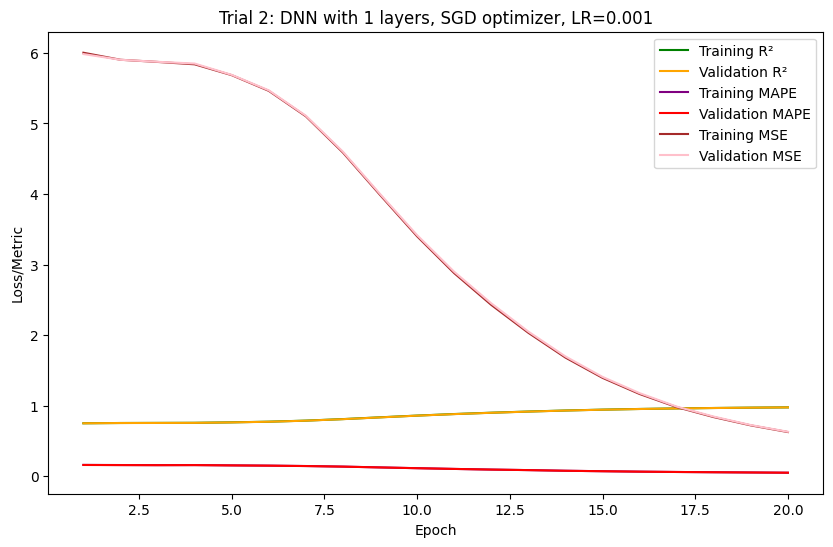

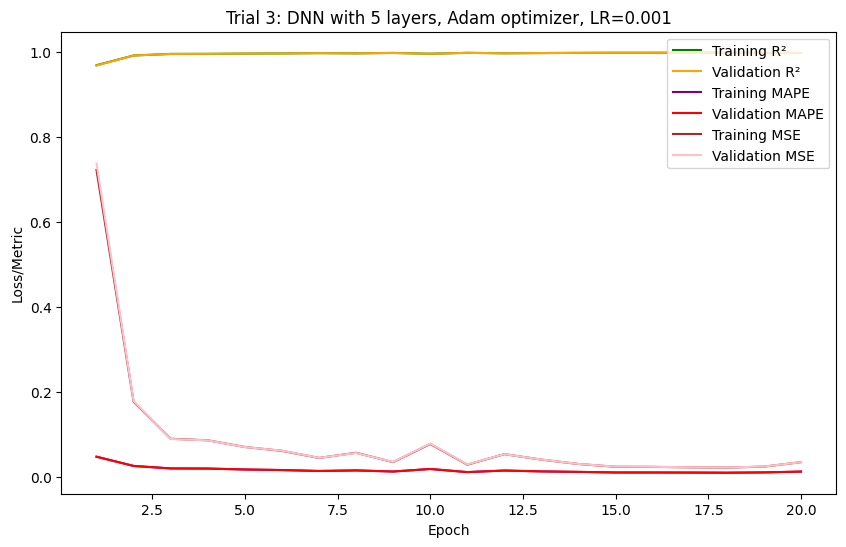

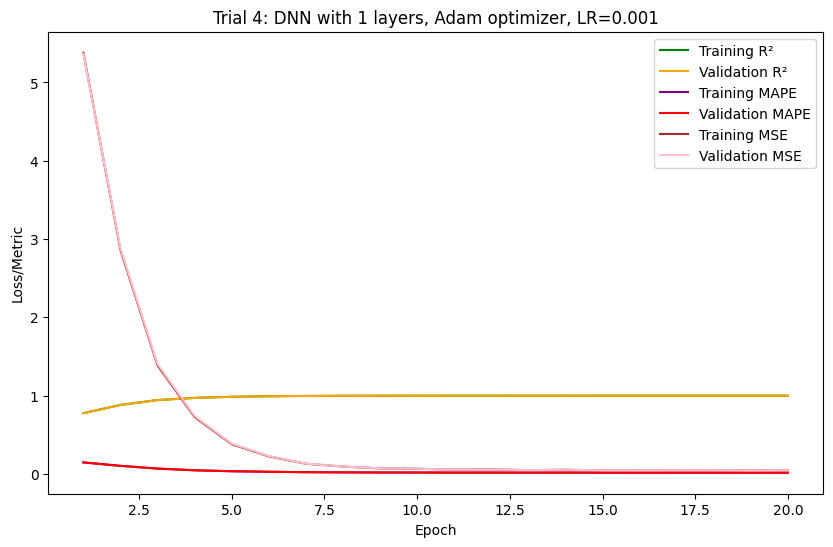

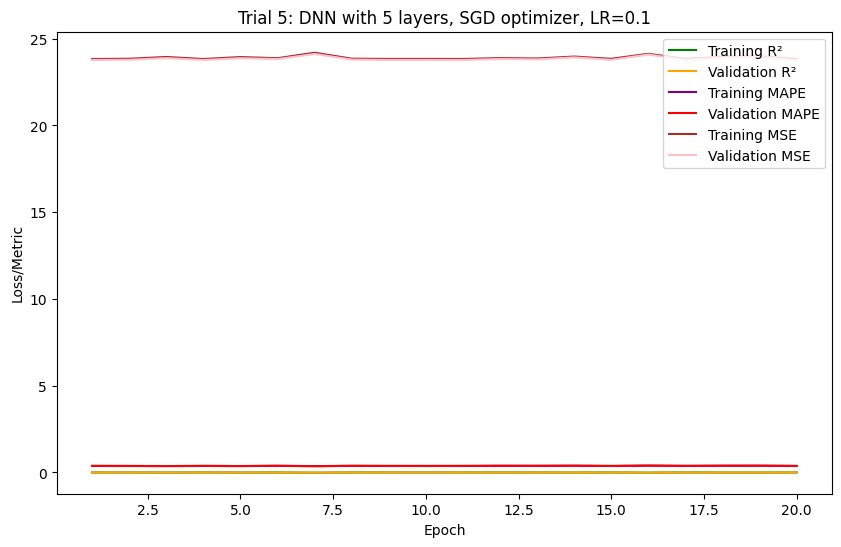

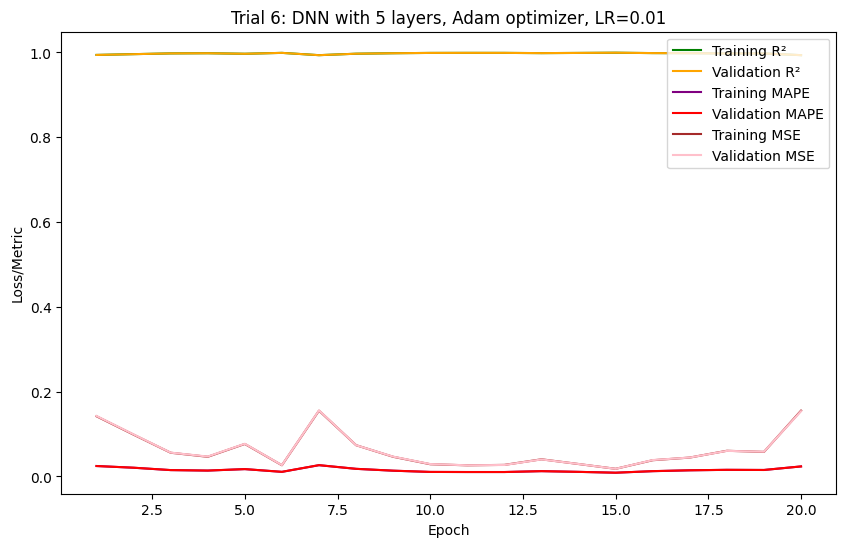

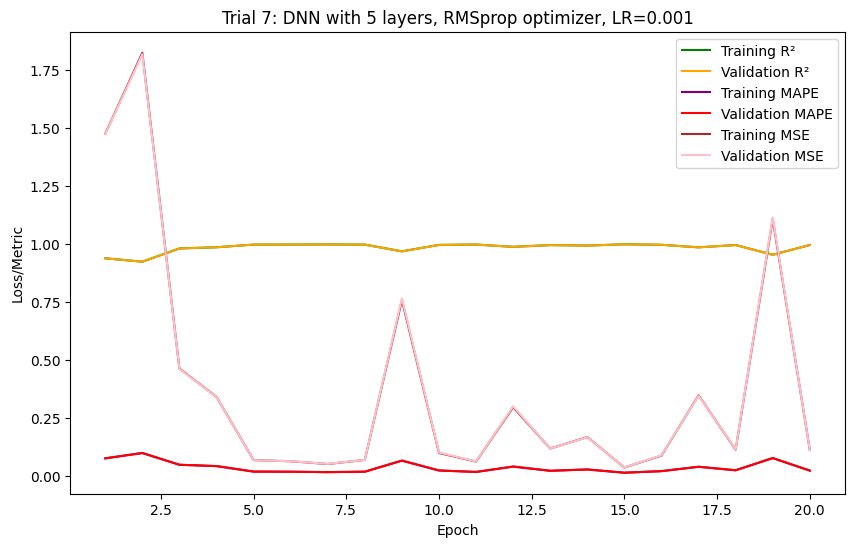

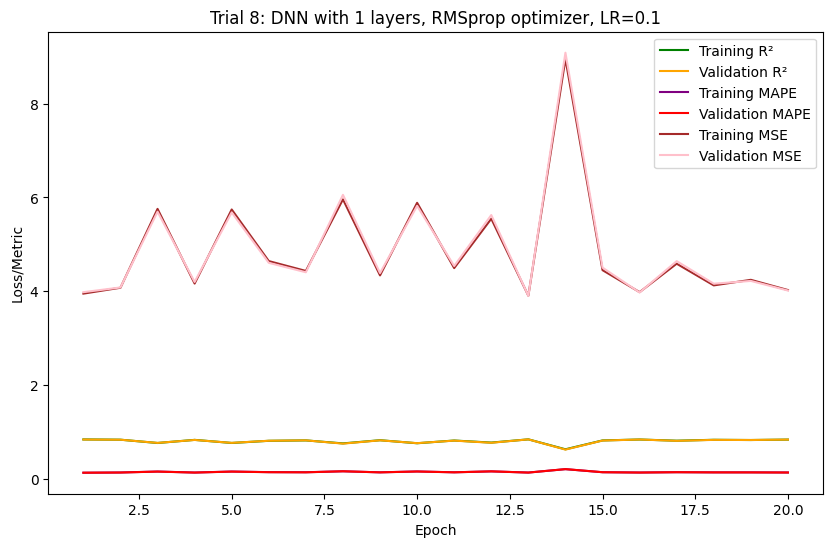

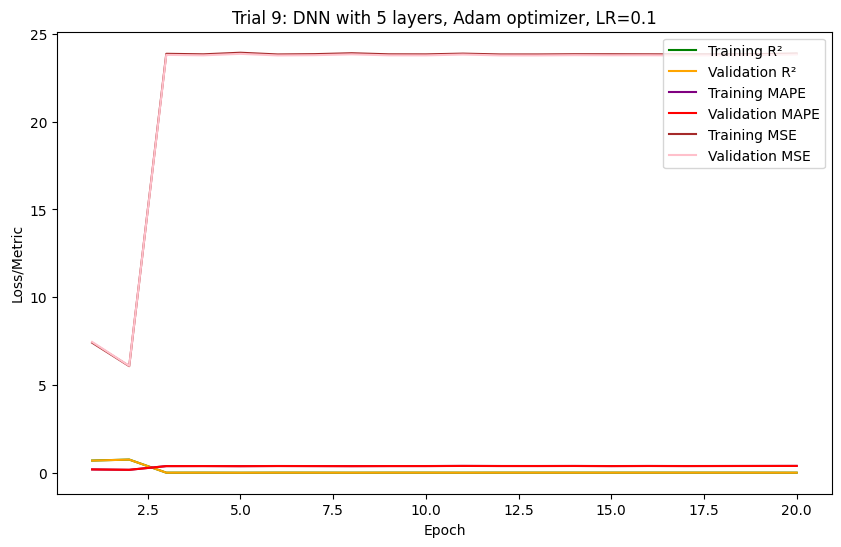

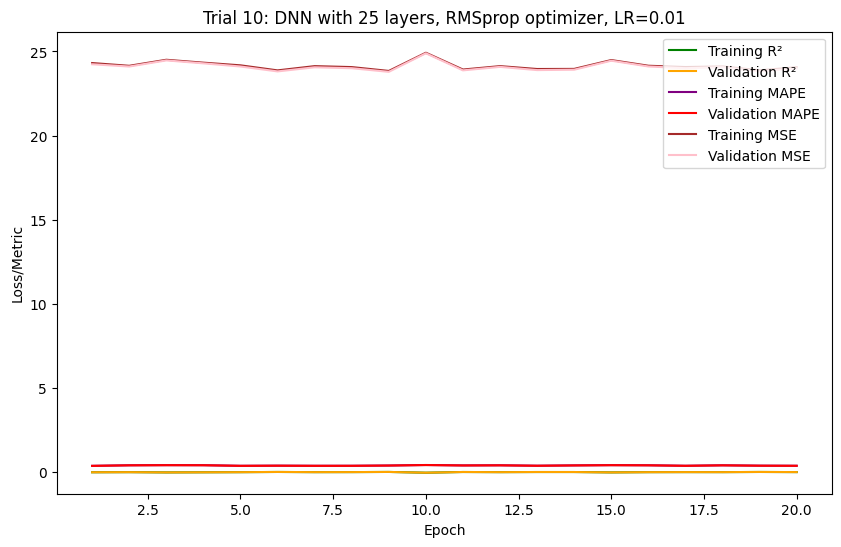

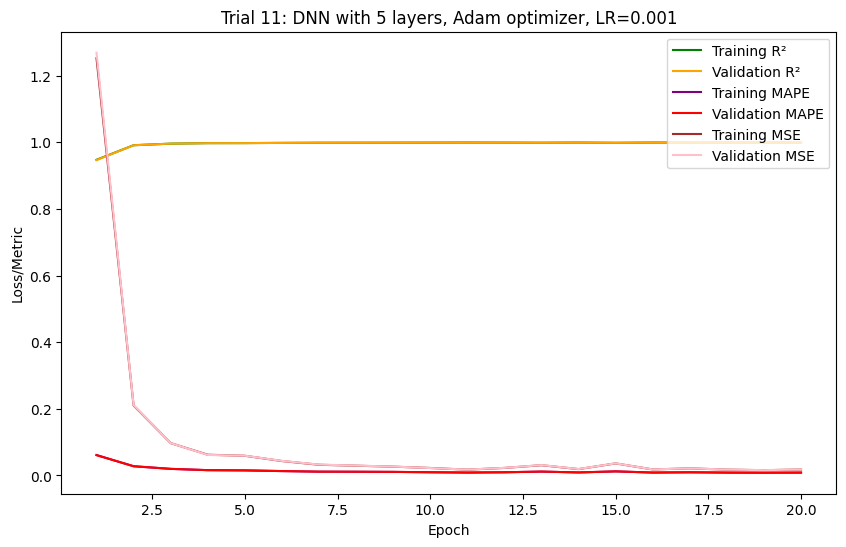

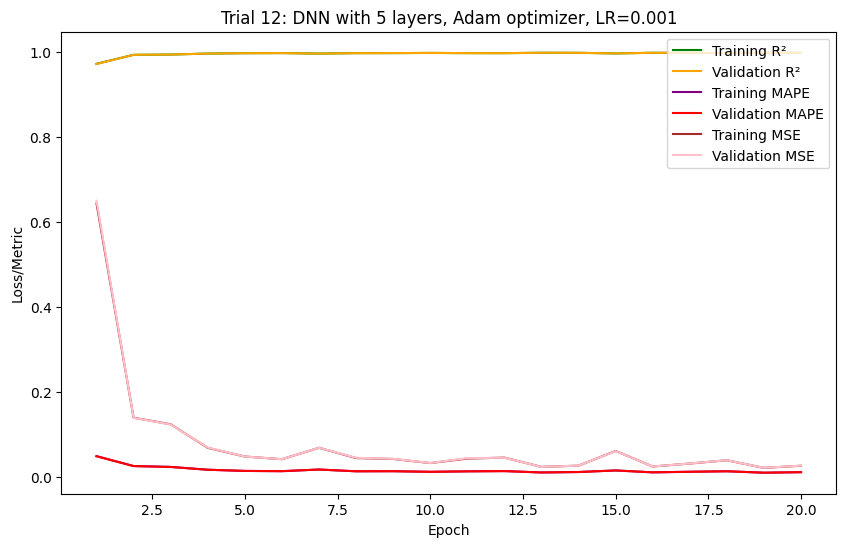

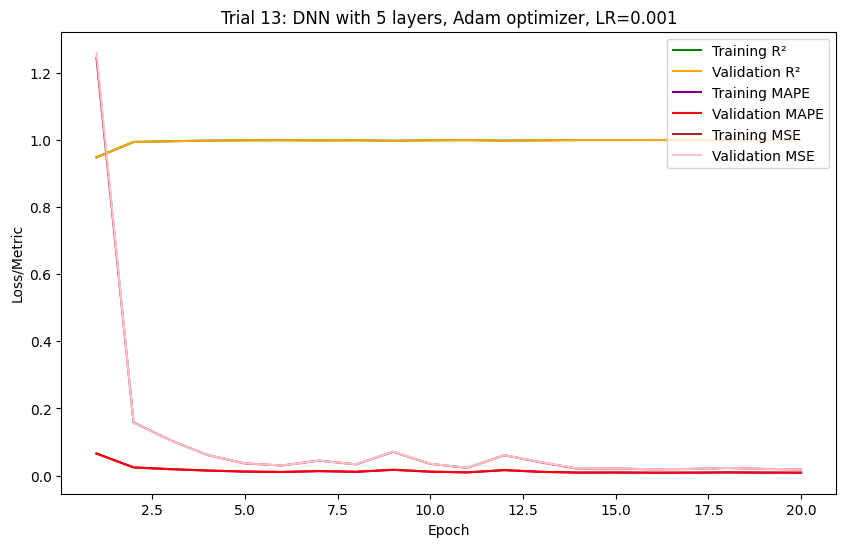

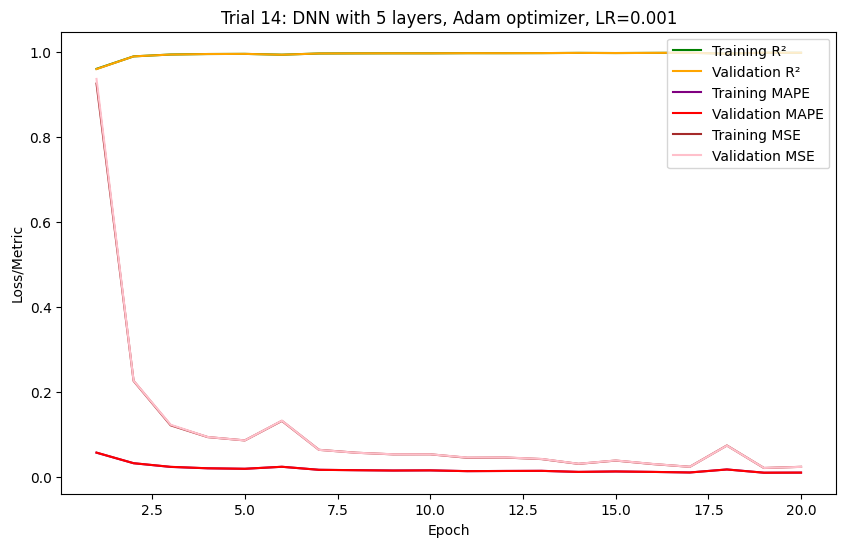

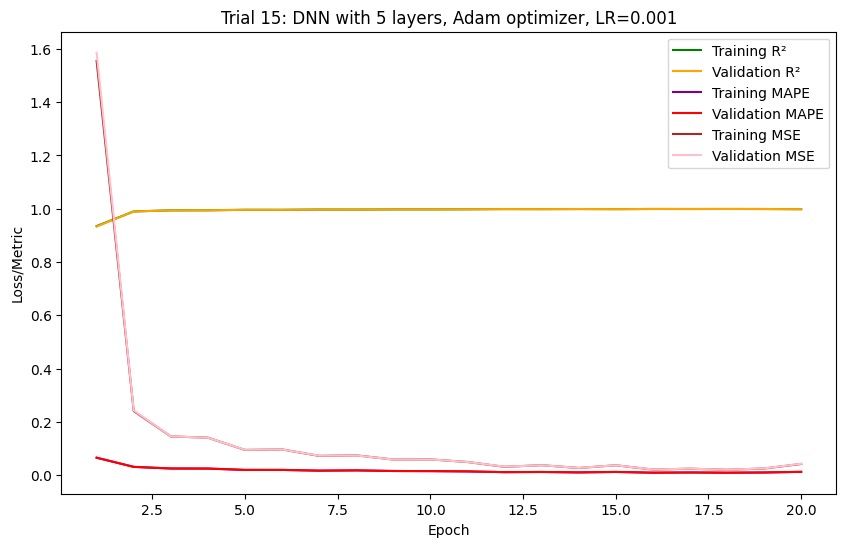

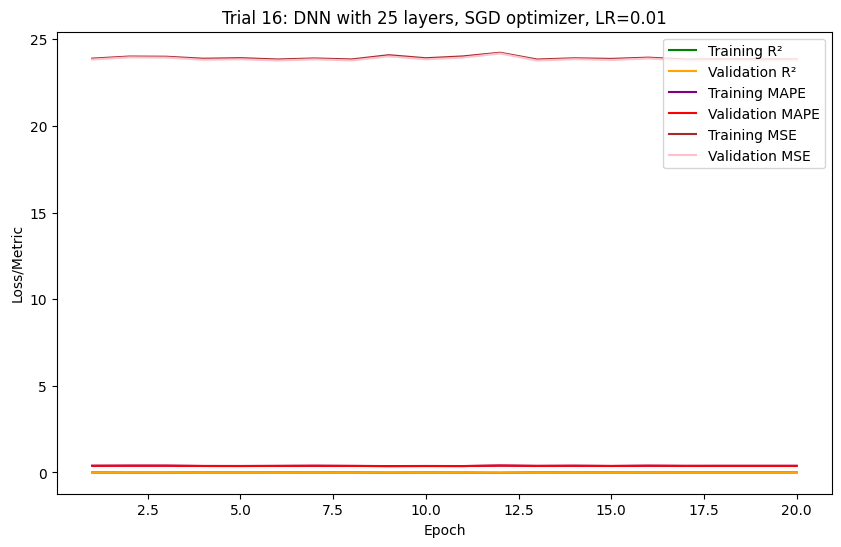

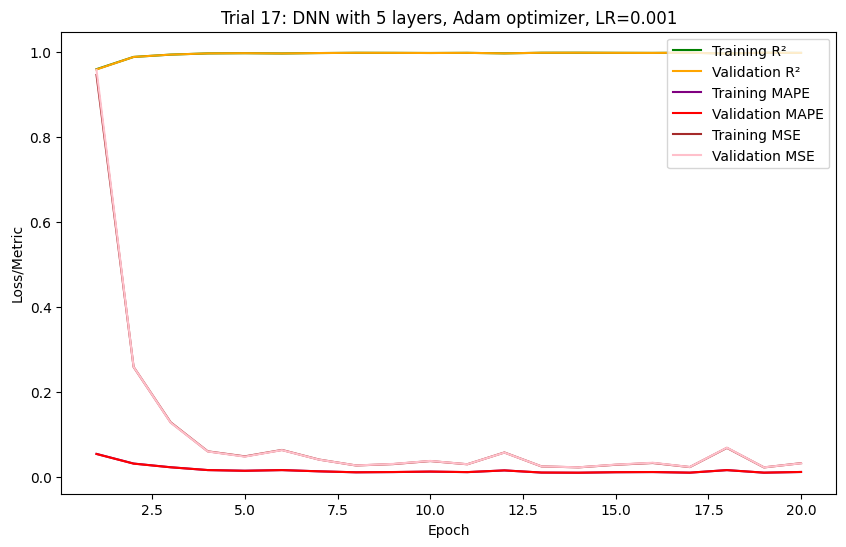

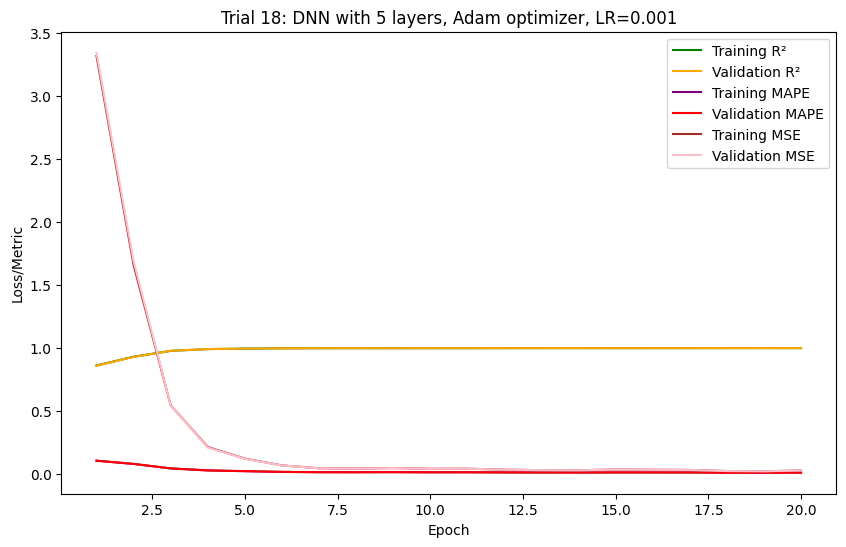

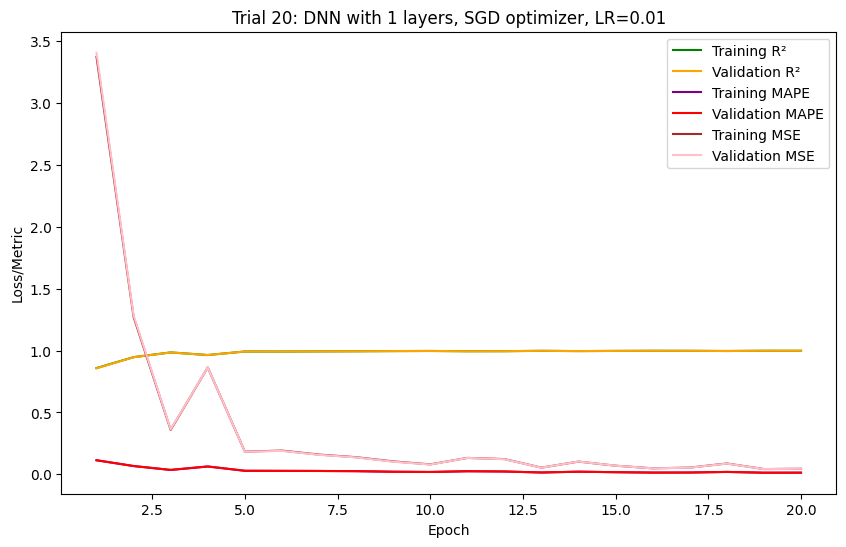

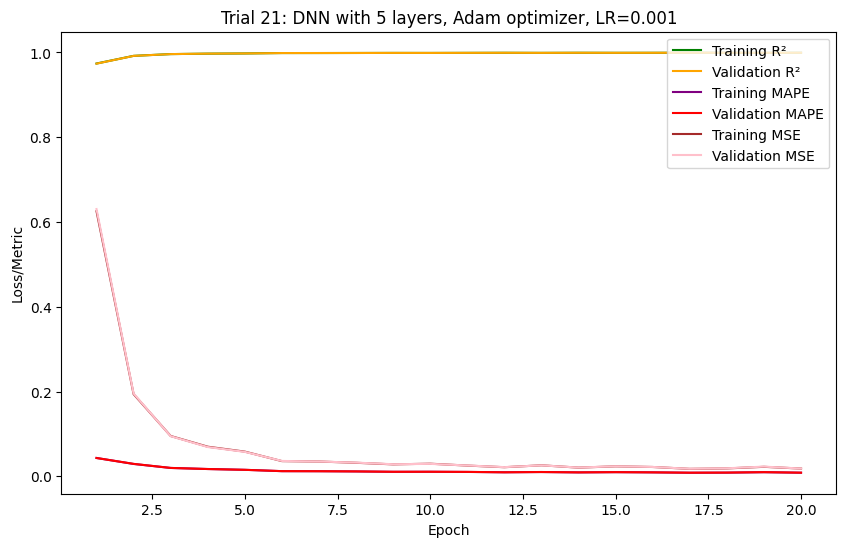

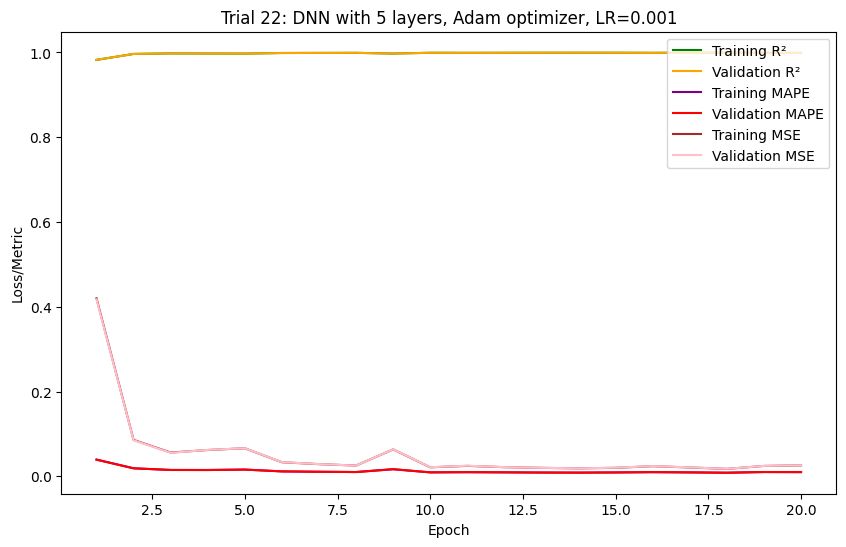

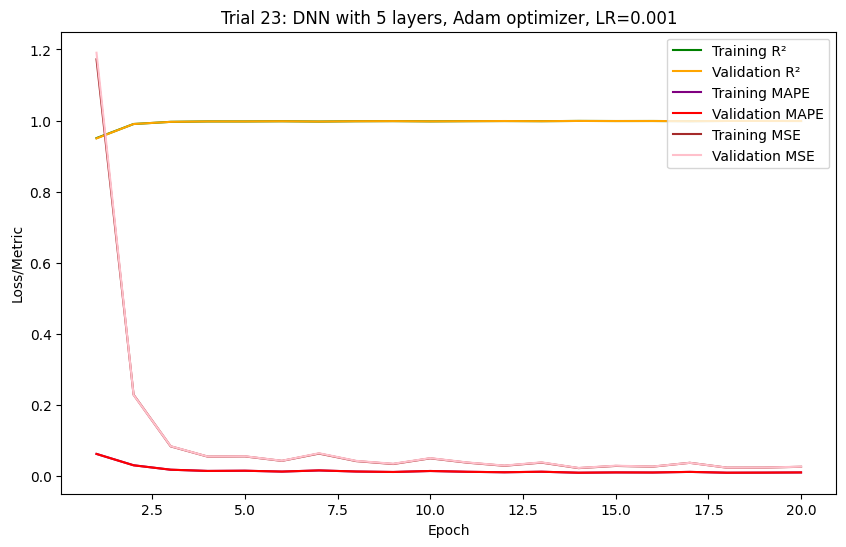

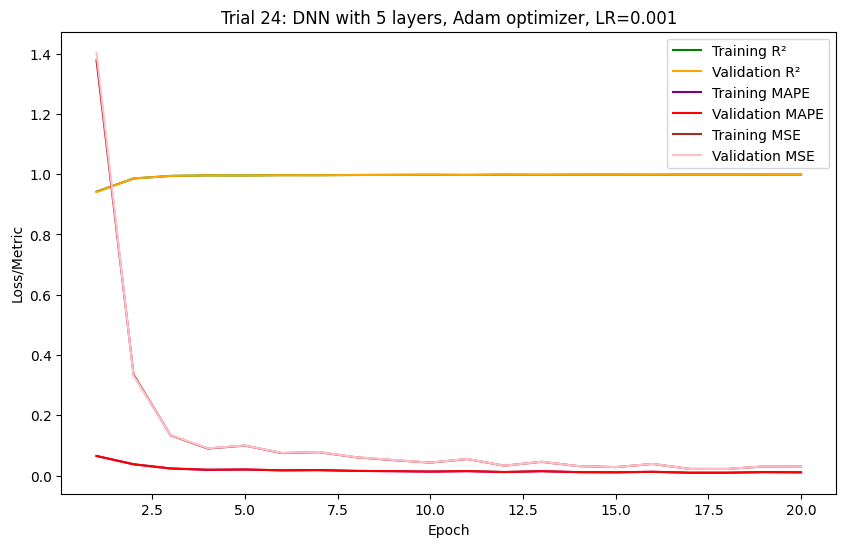

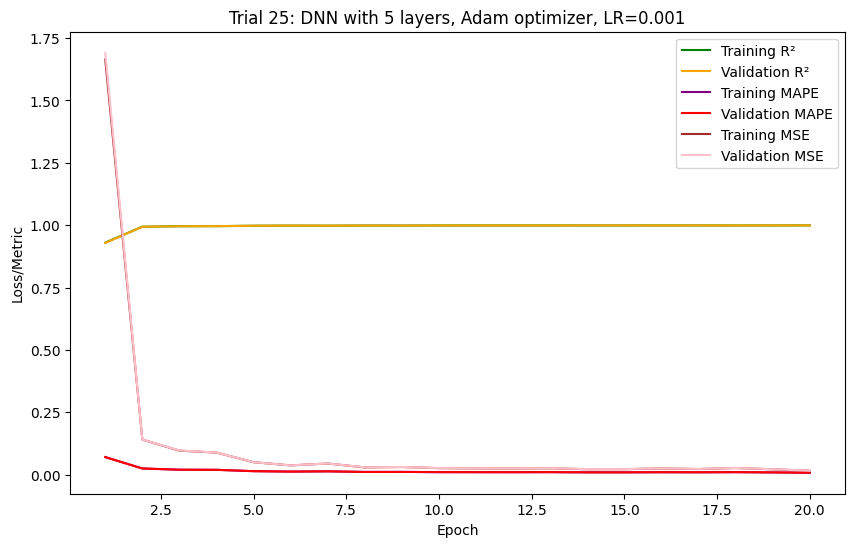

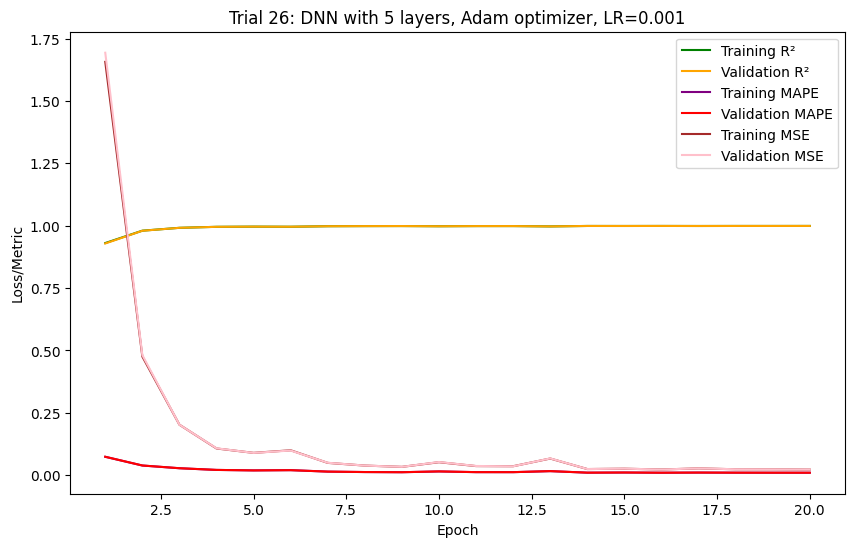

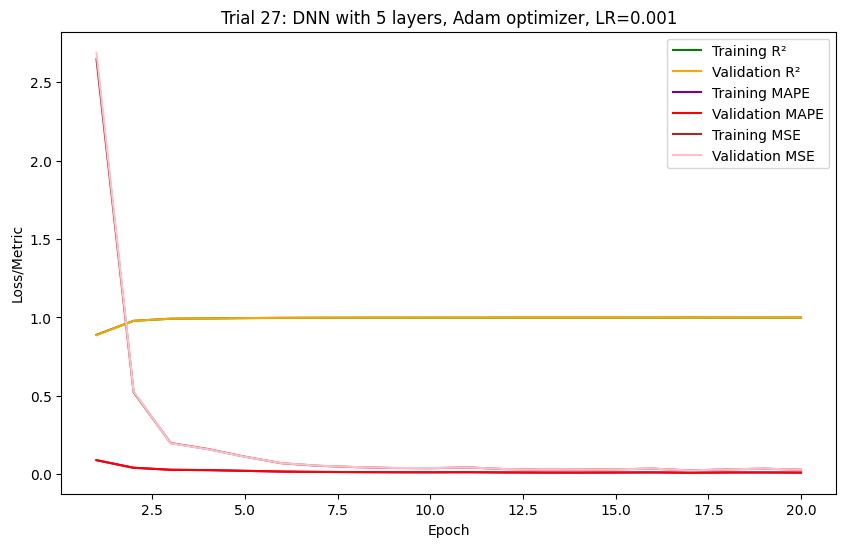

In [91]:
import matplotlib.pyplot as plt

for trial_idx, trial in enumerate(study.trials):
    try:
        if ("train_r2" in trial.user_attrs and "val_r2" in trial.user_attrs and
            "train_mse" in trial.user_attrs and "val_mse" in trial.user_attrs and
            "train_mape" in trial.user_attrs and "val_mape" in trial.user_attrs):

            train_r2 = trial.user_attrs["train_r2"]
            val_r2 = trial.user_attrs["val_r2"]
            train_mse = trial.user_attrs["train_mse"]
            val_mse = trial.user_attrs["val_mse"]
            train_mape = trial.user_attrs["train_mape"]
            val_mape = trial.user_attrs["val_mape"]

            epochs = range(1, len(train_r2) + 1)

            plt.figure(figsize=(10, 6))

            plt.plot(epochs, train_r2, label="Training R²", color="green")
            plt.plot(epochs, val_r2,   label="Validation R²", color="orange")

            plt.plot(epochs, train_mape, label="Training MAPE", color="purple")
            plt.plot(epochs, val_mape,   label="Validation MAPE", color="red")

            plt.plot(epochs, train_mse, label="Training MSE", color="brown")
            plt.plot(epochs, val_mse,   label="Validation MSE", color="pink")

            plt.title(
                f"Trial {trial_idx + 1}: "
                f"DNN with {trial.params['n_layers']} layers, "
                f"{trial.params['optimizer']} optimizer, "
                f"LR={trial.params['lr']}"
            )
            plt.xlabel("Epoch")
            plt.ylabel("Loss/Metric")
            plt.legend(loc="upper right")

            plt.show()

    except KeyError as e:
        print(f"Skipping Trial {trial_idx + 1} due to missing attribute: {e}")

In [102]:
best_trial = study.best_trial
print(f"Best trial params: {best_trial.params}")

print(f"Best trial Val_R2: {best_trial.user_attrs['val_r2'][-1]:.4f}")
print(f"Best trial Val_MAPE: {best_trial.user_attrs['val_mape'][-1]:.4f}")
print(f"Best trial Val_MSE: {best_trial.user_attrs['val_mse'][-1]:.4f}")

print(f"Best trial Train_R2: {best_trial.user_attrs['train_r2'][-1]:.4f}")
print(f"Best trial Train_MAPE: {best_trial.user_attrs['train_mape'][-1]:.4f}")
print(f"Best trial Train_MSE: {best_trial.user_attrs['train_mse'][-1]:.4f}")

Best trial params: {'n_layers': 5, 'lr': 0.001, 'optimizer': 'Adam'}
Best trial Val_R2: 0.9993
Best trial Val_MAPE: 0.0082
Best trial Val_MSE: 0.0162
Best trial Train_R2: 0.9993
Best trial Train_MAPE: 0.0081
Best trial Train_MSE: 0.0160


# DNN vs Linear Regression: Experiment Report

---

## Baseline Results (Linear Regression)
- **Training R²:** `0.75`
- **Validation R²:** `0.75`

---

## DNN Model Comparison & Results

### 1. Best Performing Model
- **Number of Layers:** `5` layers
- **Optimizer:** `Adam`
- **Learning Rate:** `0.001`
- **Final R² (Train):** `0.9993`
- **Final R² (Validation):** `0.9993`
- **Final MSE (Train):** `0.0160`
- **Final MSE (Validation):** `0.0162`

**Why This Worked:**
    - Adam converged faster and handled noisy gradients well.
    - 5-layer architecture captured non-linear patterns effectively.

---

## 2. Influence of Optimizer
**Summary:**
- Adam performed best due to adaptive learning rates.
- RMSprop was slightly slower but stabilized.
- SGD required more epochs and careful tuning.

---

## 3. Influence of Learning Rate
**Summary:**
- Lower learning rates (0.001) provided smoother convergence.
- Higher learning rates caused oscillations and overshooting.

---

## 4. Influence of DNN Architecture
**Summary:**
- 1-layer models underfitted the data.
- 5-layer models balanced complexity and generalization.
- 25-layer models overfitted the data.

---

## 5. Influence of Data Distribution
- **Linear Models (LR):** Limited capacity to capture non-linear relationships, resulting in lower performance.
- **DNN Models:** Captured non-linear interactions better, leading to higher R² and lower MSE.

**Summary:**
- Linear regression struggled with the non-linear nature of the Friedman1 dataset.
- DNNs with multiple hidden layers effectively captured complex patterns.

---

## Final Conclusions
1. The best model was a DNN with `5` layers, `Adam` optimizer, and a learning rate of `0.001`.
2. Adam consistently performed better due to its adaptive learning rate mechanism.
3. Learning rate had a significant impact, with lower rates providing smoother convergence.
4. 5-layer models provided the best balance between complexity and generalization.
5. DNNs outperformed Linear Regression due to their ability to handle non-linear patterns.